# ESC-50 EDA: Octave-band statistics + overlap analysis

目的：**「ラベルに共通する音の特徴は何か」「他ラベルと何が違うか」**を、なるべく **上流（音の性質に近い表現）**から丁寧に見ます。

このノートでやること（あなたの要求 + 追加）：
- label ごとに wav を読み込み
- 周波数スペクトル / PSD を作成（Welch 法）
- 音量を無次元化（RMS 正規化）して比較可能にする（※絶対 SPL ではなく相対比較）
- 縦軸を dB（**10log10(power)**）で表示
- **1/N オクターブバンド**で周波数ビンを集約（power を帯域積分→dB）
- label ごとに各帯域の平均/標準偏差を算出 & 可視化
- label 間差の分析（効果量・検定・ランキング）
- label ごとに帯域間の相関行列を計算 & 比較
- **分布オーバーラップ**（面積/体積）の推定  
  - 1次元：OVL (overlap coefficient)  
  - 多次元：ガウス近似の Bhattacharyya / Hellinger（軽くて頑健）  
  - 追加：kNN 混合スコア（非線形写像の “混ざり具合” を測る）
- **特徴表現候補を複数用意**し、どれが最もオーバーラップが小さいかをランキング  
  - octave-band dB  
  - log-mel（あなたの学習特徴）要約  
  - 追加の簡易スペクトル統計（centroid 等）

> dB の四則演算注意：  
> 平均や和は **線形（power）領域**で行い、最後に dB に戻すのが基本です。  
> dB をそのまま足し引き平均すると物理量として壊れます。


In [ ]:
# Optional: editable install (project root)
# !pip install -e .

import sys
print("python:", sys.version)


## 0) Project root + config + metadata/splits（src再利用）

In [1]:
from __future__ import annotations

from pathlib import Path
import yaml
import numpy as np
import pandas as pd

def find_project_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / "config").exists() and (p / "src").exists():
            return p
    raise FileNotFoundError("Project root not found. Open this notebook somewhere under the project folder.")

ROOT = find_project_root()
print("ROOT =", ROOT)

cfg = yaml.safe_load((ROOT / "config" / "default.yaml").read_text(encoding="utf-8"))

from src.data.metadata import load_esc50_metadata
from src.data.split import SplitConfig, make_splits

meta_csv = (ROOT / Path(cfg["paths"]["meta_csv"])).resolve()
audio_dir = (ROOT / Path(cfg["paths"]["audio_dir"])).resolve()

df = load_esc50_metadata(meta_csv)
print("meta rows:", len(df), "num_classes:", df["target"].nunique())

s_cfg = cfg["split"]
split_cfg = SplitConfig(
    method=s_cfg["method"],
    train_folds=list(s_cfg.get("train_folds", [])),
    val_folds=list(s_cfg.get("val_folds", [])),
    test_folds=list(s_cfg.get("test_folds", [])),
    kfold_num_folds=int(s_cfg.get("kfold", {}).get("num_folds", 5)),
    kfold_test_fold=int(s_cfg.get("kfold", {}).get("test_fold", 1)),
    kfold_val_fold=int(s_cfg.get("kfold", {}).get("val_fold", 2)),
    random_seed=int(cfg["project"]["seed"]),
)
splits = make_splits(df, split_cfg)
print({k: len(v) for k, v in splits.items()})

target_to_cat = df.sort_values("target").drop_duplicates("target").set_index("target")["category"].to_dict()
cat_to_target = {v: int(k) for k, v in target_to_cat.items()}


ROOT = C:\Users\hirok\code\02_sound\esc50_cnn
meta rows: 2000 num_classes: 50
{'train': 1200, 'val': 400, 'test': 400}


## 1) 音読み込み（soundfile）+ 前処理（RMS正規化 / 長さ統一 / resample）

In [2]:
import math
import soundfile as sf
from scipy.signal import resample_poly

SAMPLE_RATE = int(cfg.get("audio", {}).get("sample_rate", 44100))
DURATION_SEC = float(cfg.get("audio", {}).get("duration_sec", 5.0))
TARGET_LEN = int(round(SAMPLE_RATE * DURATION_SEC))

def load_wav_mono(path: Path) -> tuple[np.ndarray, int]:
    x, sr = sf.read(str(path), always_2d=False)
    if x.ndim == 2:
        x = x.mean(axis=1)
    x = x.astype(np.float32)
    return x, int(sr)

def resample_if_needed(x: np.ndarray, sr: int, target_sr: int) -> np.ndarray:
    if sr == target_sr:
        return x
    g = math.gcd(sr, target_sr)
    up = target_sr // g
    down = sr // g
    return resample_poly(x, up=up, down=down).astype(np.float32)

def fix_length(x: np.ndarray, target_len: int) -> np.ndarray:
    if x.shape[0] > target_len:
        return x[:target_len]
    if x.shape[0] < target_len:
        pad = target_len - x.shape[0]
        return np.pad(x, (0, pad), mode="constant")
    return x

def rms(x: np.ndarray, eps: float = 1e-12) -> float:
    return float(np.sqrt(np.mean(x*x) + eps))

def normalize_rms(x: np.ndarray, target_rms: float = 1.0, eps: float = 1e-12) -> np.ndarray:
    r = rms(x, eps=eps)
    return x * (target_rms / max(r, eps))

def load_preprocess(filename: str, *, rms_norm: bool = True) -> np.ndarray:
    path = audio_dir / filename
    x, sr = load_wav_mono(path)
    x = resample_if_needed(x, sr, SAMPLE_RATE)
    x = fix_length(x, TARGET_LEN)
    if rms_norm:
        x = normalize_rms(x, target_rms=1.0)  # dimensionless loudness normalization
    return x

# quick sanity
fn0 = df.iloc[0]["filename"]
x0 = load_preprocess(fn0)
print("example:", fn0, "shape:", x0.shape, "rms:", rms(x0))


example: 1-100032-A-0.wav shape: (220500,) rms: 1.0


## 2) PSD → dB → 1/N オクターブバンド
- PSD: Welch 法（power/Hz）
- band level: PSD を帯域で積分して power に戻す → 10log10(power)


In [3]:
from scipy.signal import welch

def compute_psd(x: np.ndarray, sr: int, nperseg: int = 2048, noverlap: int | None = None):
    if noverlap is None:
        noverlap = nperseg // 2
    f, Pxx = welch(x, fs=sr, nperseg=nperseg, noverlap=noverlap, detrend="constant", scaling="density")
    return f.astype(np.float32), Pxx.astype(np.float32)

def octave_band_edges(fc: float, N: int) -> tuple[float, float]:
    k = 2.0 ** (1.0 / (2.0 * N))
    return fc / k, fc * k

def make_octave_centers(fmin: float, fmax: float, N: int) -> np.ndarray:
    if fmin <= 0:
        raise ValueError("fmin must be > 0 for octave bands.")
    ratio = 2.0 ** (1.0 / N)
    centers = []
    fc = fmin
    while fc <= fmax:
        centers.append(fc)
        fc *= ratio
    return np.array(centers, dtype=np.float32)

def band_power_from_psd(f: np.ndarray, Pxx: np.ndarray, f_lo: float, f_hi: float) -> float:
    mask = (f >= f_lo) & (f < f_hi)
    if not np.any(mask):
        return 0.0
    return float(np.trapz(Pxx[mask], f[mask]))

def power_to_db(p: float, ref: float = 1.0, eps: float = 1e-20) -> float:
    return float(10.0 * np.log10(max(p, eps) / ref))

def octave_band_levels_db(x: np.ndarray, sr: int, *, N: int = 3, fmin: float = 25.0, fmax: float | None = None,
                          nperseg: int = 2048) -> tuple[np.ndarray, np.ndarray]:
    fmax = float(fmax if fmax is not None else (sr / 2.0))
    f, Pxx = compute_psd(x, sr, nperseg=nperseg)
    centers = make_octave_centers(fmin, min(fmax, sr/2.0), N)
    levels = []
    for fc in centers:
        lo, hi = octave_band_edges(float(fc), N)
        p = band_power_from_psd(f, Pxx, lo, hi)
        levels.append(power_to_db(p, ref=1.0))
    return centers, np.array(levels, dtype=np.float32)

centers, lev = octave_band_levels_db(x0, SAMPLE_RATE, N=3, fmin=25.0, fmax=20000.0)
print("bands:", len(centers), "level_db shape:", lev.shape, "example first bands:", list(zip(centers[:5], lev[:5])))


bands: 29 level_db shape: (29,) example first bands: [(np.float32(25.0), np.float32(-200.0)), (np.float32(31.498026), np.float32(-200.0)), (np.float32(39.685028), np.float32(-200.0)), (np.float32(50.0), np.float32(-200.0)), (np.float32(62.99605), np.float32(-200.0))]


C:\Users\hirok\AppData\Local\Temp\ipykernel_17108\4290398867.py:28: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(Pxx[mask], f[mask]))


## 3) 全データ（or サブセット）に octave-band を適用して特徴テーブルを作る（キャッシュ付き）

In [6]:
import hashlib
from tqdm.auto import tqdm

USE_ALL = True
MAX_PER_LABEL = 40
OCT_N = 12
OCT_FMIN = 25.0
OCT_FMAX = 20000.0
WELCH_NPERSEG = 2048

def make_cache_dir() -> Path:
    key = {
        "sr": SAMPLE_RATE, "dur": DURATION_SEC, "octN": OCT_N, "fmin": OCT_FMIN, "fmax": OCT_FMAX,
        "nperseg": WELCH_NPERSEG, "rms_norm": True,
    }
    h = hashlib.sha1(repr(sorted(key.items())).encode("utf-8")).hexdigest()[:12]
    d = (ROOT / "data" / "processed" / "eda_octave" / h)
    d.mkdir(parents=True, exist_ok=True)
    (d / "config.json").write_text(pd.Series(key).to_json(), encoding="utf-8")
    return d

CACHE_DIR = make_cache_dir()
# Cache file: use Parquet if available, otherwise CSV (gzip) fallback.
CACHE_FILE_PARQUET = CACHE_DIR / "octave_features.parquet"
CACHE_FILE_CSV = CACHE_DIR / "octave_features.csv.gz"

def _parquet_available() -> bool:
    try:
        import pyarrow  # noqa: F401
        return True
    except Exception:
        try:
            import fastparquet  # noqa: F401
            return True
        except Exception:
            return False

def save_table(df: pd.DataFrame) -> Path:
    if _parquet_available():
        df.to_parquet(CACHE_FILE_PARQUET, index=False)
        return CACHE_FILE_PARQUET
    df.to_csv(CACHE_FILE_CSV, index=False, compression="gzip")
    return CACHE_FILE_CSV

def load_table() -> pd.DataFrame:
    if CACHE_FILE_PARQUET.exists():
        return pd.read_parquet(CACHE_FILE_PARQUET)
    if CACHE_FILE_CSV.exists():
        return pd.read_csv(CACHE_FILE_CSV)
    raise FileNotFoundError("No cache file found")

def cache_path_for_print() -> Path:
    if CACHE_FILE_PARQUET.exists():
        return CACHE_FILE_PARQUET
    if CACHE_FILE_CSV.exists():
        return CACHE_FILE_CSV
    return CACHE_FILE_PARQUET if _parquet_available() else CACHE_FILE_CSV


def select_df(df: pd.DataFrame) -> pd.DataFrame:
    if USE_ALL:
        return df.copy()
    out = []
    for cat, g in df.groupby("category"):
        out.append(g.sample(n=min(MAX_PER_LABEL, len(g)), random_state=int(cfg["project"]["seed"])))
    return pd.concat(out, axis=0).reset_index(drop=True)

df_use = select_df(df)
print("df_use:", len(df_use), "unique categories:", df_use["category"].nunique(), "cache:", cache_path_for_print())

if CACHE_FILE_PARQUET.exists() or CACHE_FILE_CSV.exists():
    df_feat = load_table()
    print("Loaded cache:", df_feat.shape, "from", cache_path_for_print())
else:
    rows = []
    for _, r in tqdm(df_use.iterrows(), total=len(df_use), desc="octave features"):
        fn = r["filename"]
        y = int(r["target"])
        cat = r["category"]
        x = load_preprocess(fn, rms_norm=True)
        centers, lev_db = octave_band_levels_db(
            x, SAMPLE_RATE, N=OCT_N, fmin=OCT_FMIN, fmax=OCT_FMAX, nperseg=WELCH_NPERSEG
        )
        row = {"filename": fn, "target": y, "category": cat}
        for i, fc in enumerate(centers):
            row[f"band_{i:03d}_fc_hz"] = float(fc)
            row[f"band_{i:03d}_db"] = float(lev_db[i])
        rows.append(row)

    df_feat = pd.DataFrame(rows)
    written = save_table(df_feat)
    print("Wrote cache:", df_feat.shape, "->", written)

df_feat.head()


df_use: 2000 unique categories: 50 cache: C:\Users\hirok\code\02_sound\esc50_cnn\data\processed\eda_octave\7564ad9cfefc\octave_features.parquet


octave features:   0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\hirok\AppData\Local\Temp\ipykernel_17108\4290398867.py:28: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(Pxx[mask], f[mask]))
octave features: 100%|██████████| 2000/2000 [00:20<00:00, 99.59it/s] 

Wrote cache: (2000, 235) -> C:\Users\hirok\code\02_sound\esc50_cnn\data\processed\eda_octave\7564ad9cfefc\octave_features.parquet


,filename,target,category,band_000_fc_hz,band_000_db,band_001_fc_hz,band_001_db,band_002_fc_hz,band_002_db,band_003_fc_hz,...,band_111_fc_hz,band_111_db,band_112_fc_hz,band_112_db,band_113_fc_hz,band_113_db,band_114_fc_hz,band_114_db,band_115_fc_hz,band_115_db
0,1-100032-A-0.wav,0,dog,25.0,-200.0,26.486578,-200.0,28.061552,-200.0,29.730177,...,15221.850586,-55.027409,16126.989258,-57.699196,17085.949219,-73.482101,18101.933594,-65.997780,19178.330078,-55.365723
1,1-100038-A-14.wav,14,chirping_birds,25.0,-200.0,26.486578,-200.0,28.061552,-200.0,29.730177,...,15221.850586,-52.011555,16126.989258,-52.873589,17085.949219,-51.508144,18101.933594,-89.543518,19178.330078,-89.967072
2,1-100210-A-36.wav,36,vacuum_cleaner,25.0,-200.0,26.486578,-200.0,28.061552,-200.0,29.730177,...,15221.850586,-28.294041,16126.989258,-38.228161,17085.949219,-38.654049,18101.933594,-41.137661,19178.330078,-51.671993
3,1-100210-B-36.wav,36,vacuum_cleaner,25.0,-200.0,26.486578,-200.0,28.061552,-200.0,29.730177,...,15221.850586,-29.861889,16126.989258,-39.801109,17085.949219,-41.187435,18101.933594,-45.263836,19178.330078,-53.415306
4,1-101296-A-19.wav,19,thunderstorm,25.0,-200.0,26.486578,-200.0,28.061552,-200.0,29.730177,...,15221.850586,-42.466629,16126.989258,-49.401978,17085.949219,-50.921440,18101.933594,-53.232311,19178.330078,-65.740814


## 4) ラベルごとの平均・標準偏差（octave-band dB）を可視化

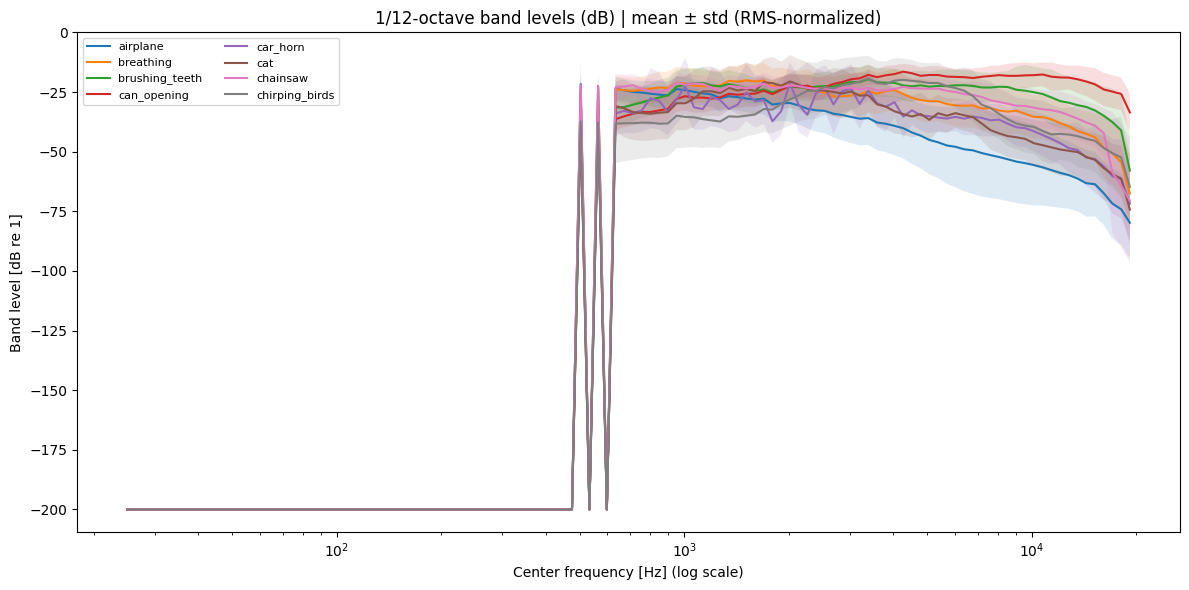

In [7]:
import matplotlib.pyplot as plt

band_db_cols = sorted([c for c in df_feat.columns if c.endswith("_db")])
band_fc_cols = sorted([c for c in df_feat.columns if c.endswith("_fc_hz")])
centers = np.array([df_feat.loc[0, c] for c in band_fc_cols], dtype=np.float32)

g = df_feat.groupby("category")[band_db_cols]
mean_db = g.mean()
std_db = g.std()

LABELS_TO_PLOT = []  # e.g. ["dog","rain","chainsaw"] ; empty -> plot first 8 categories
cats = LABELS_TO_PLOT if LABELS_TO_PLOT else mean_db.index[:8].tolist()

plt.figure(figsize=(12, 6))
for cat in cats:
    m = mean_db.loc[cat].to_numpy()
    s = std_db.loc[cat].to_numpy()
    plt.semilogx(centers, m, label=cat)
    plt.fill_between(centers, m - s, m + s, alpha=0.15)

plt.title(f"1/{OCT_N}-octave band levels (dB) | mean ± std (RMS-normalized)")
plt.xlabel("Center frequency [Hz] (log scale)")
plt.ylabel("Band level [dB re 1]")
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


## 5) ラベル間差の分析（どの帯域が効いている？）

c:\Users\hirok\venv\py312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\hirok\venv\py312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\hirok\venv\py312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\hirok\venv\py312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\hirok\venv\py312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: ConstantInp

Top bands by ANOVA F:
  fc= 10763.5 Hz | F=40.232
  fc=  6040.8 Hz | F=39.496
  fc=  8063.5 Hz | F=39.378
  fc= 10159.4 Hz | F=39.284
  fc=  5701.8 Hz | F=39.162
  fc=  9589.2 Hz | F=38.797
  fc= 11403.5 Hz | F=38.723
  fc= 12800.0 Hz | F=38.714
  fc=  6400.0 Hz | F=38.685
  fc=  7183.8 Hz | F=38.373


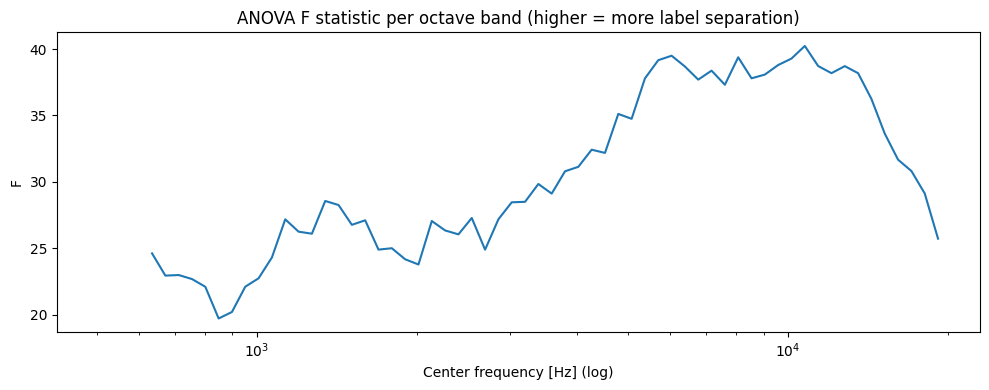

In [8]:
from scipy.stats import f_oneway

F = []
for col in band_db_cols:
    groups = [g[col].to_numpy() for _, g in df_feat.groupby("category")]
    try:
        stat = f_oneway(*groups)
        F.append(float(stat.statistic))
    except Exception:
        F.append(np.nan)

F = np.array(F, dtype=float)

topk = 10
idx = np.argsort(-np.nan_to_num(F, nan=-1e9))[:topk]
print("Top bands by ANOVA F:")
for i in idx:
    print(f"  fc={centers[i]:8.1f} Hz | F={F[i]:.3f}")

plt.figure(figsize=(10,4))
plt.semilogx(centers, F)
plt.title("ANOVA F statistic per octave band (higher = more label separation)")
plt.xlabel("Center frequency [Hz] (log)")
plt.ylabel("F")
plt.tight_layout()
plt.show()

def cohens_d(a: np.ndarray, b: np.ndarray, eps: float = 1e-12) -> float:
    ma, mb = float(a.mean()), float(b.mean())
    va, vb = float(a.var(ddof=1)), float(b.var(ddof=1))
    n1, n2 = len(a), len(b)
    sp = math.sqrt(((n1-1)*va + (n2-1)*vb) / max(n1+n2-2, 1))
    return (ma - mb) / max(sp, eps)

LABEL_A = None  # e.g. "dog"
LABEL_B = None  # e.g. "rain"

if LABEL_A and LABEL_B:
    da = df_feat[df_feat["category"]==LABEL_A]
    db_ = df_feat[df_feat["category"]==LABEL_B]
    d = np.array([cohens_d(da[c].to_numpy(), db_[c].to_numpy()) for c in band_db_cols], dtype=float)
    plt.figure(figsize=(10,4))
    plt.semilogx(centers, d)
    plt.axhline(0, linewidth=1)
    plt.title(f"Cohen's d per band: {LABEL_A} vs {LABEL_B} (positive means {LABEL_A} higher)")
    plt.xlabel("Center frequency [Hz] (log)")
    plt.ylabel("Cohen's d")
    plt.tight_layout()
    plt.show()


## 6) ラベルごとの帯域間相関行列（band-band correlation）

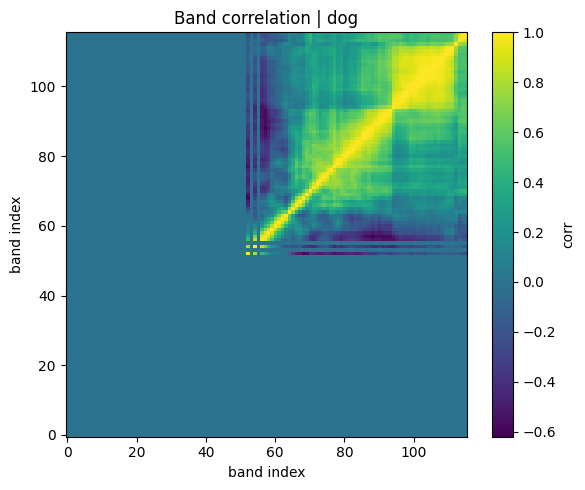

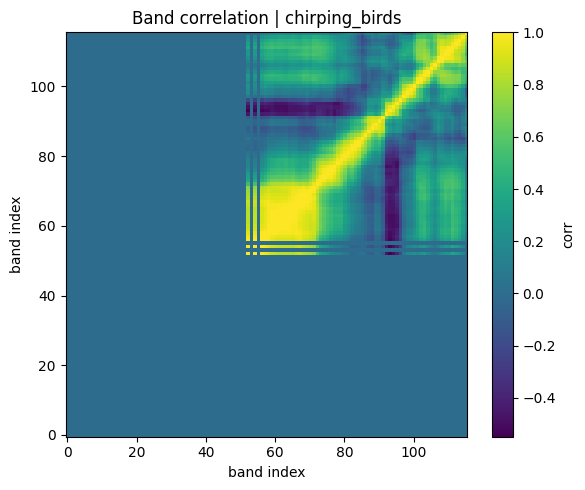

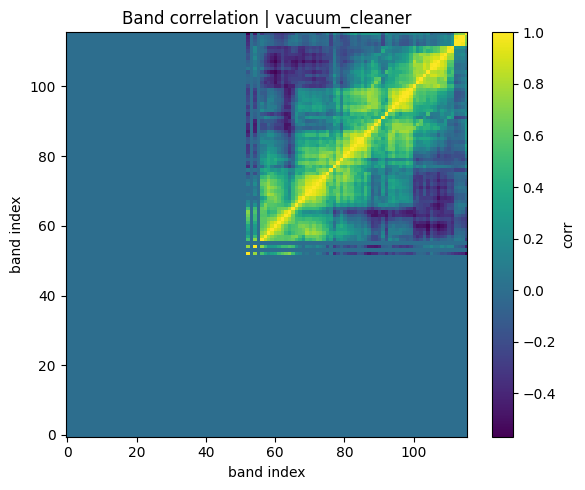

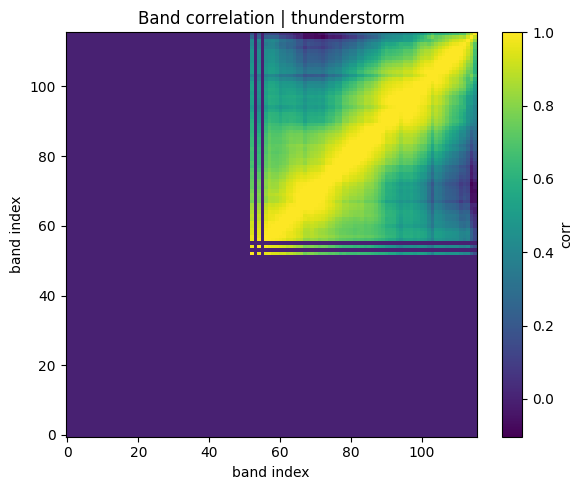

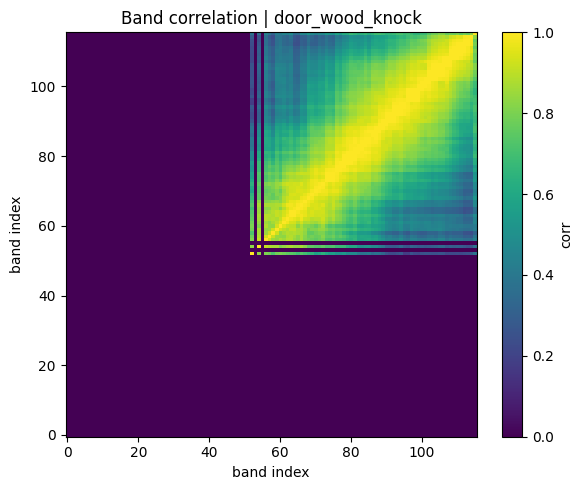

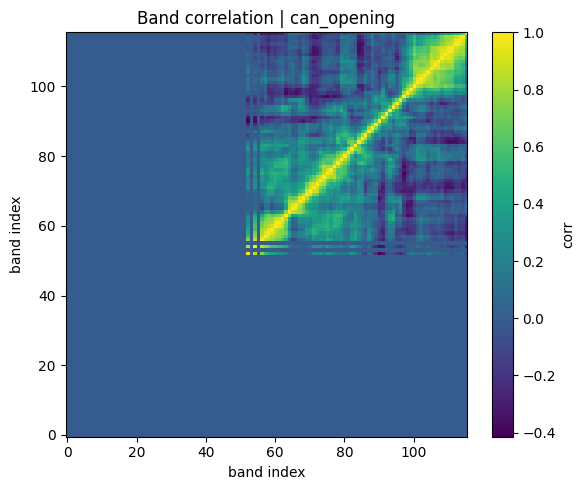

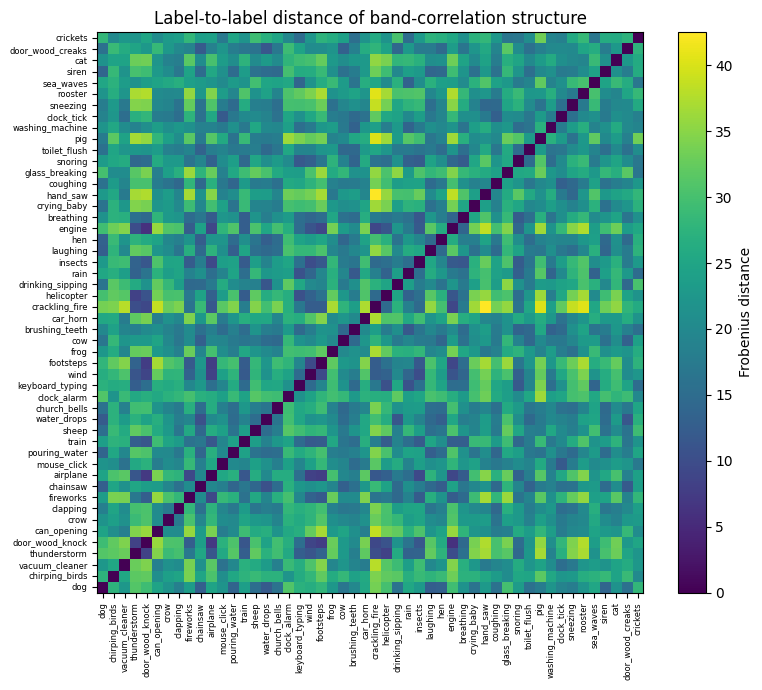

In [9]:
from sklearn.preprocessing import StandardScaler

def corr_matrix(df_sub: pd.DataFrame, cols: list[str]) -> np.ndarray:
    X = df_sub[cols].to_numpy()
    X = X - X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True)
    sd[sd < 1e-12] = 1e-12
    X = X / sd
    C = (X.T @ X) / max(X.shape[0]-1, 1)
    return np.clip(C, -1.0, 1.0)

cats = df_feat["category"].unique().tolist()
SHOW_CATS = cats[:6]

for cat in SHOW_CATS:
    C = corr_matrix(df_feat[df_feat["category"]==cat], band_db_cols)
    plt.figure(figsize=(6,5))
    plt.imshow(C, aspect="auto", origin="lower")
    plt.colorbar(label="corr")
    plt.title(f"Band correlation | {cat}")
    plt.xlabel("band index")
    plt.ylabel("band index")
    plt.tight_layout()
    plt.show()

corrs = {cat: corr_matrix(df_feat[df_feat["category"]==cat], band_db_cols) for cat in cats}
cat_list = list(corrs.keys())
K = len(cat_list)
D = np.zeros((K, K), dtype=np.float32)
for i in range(K):
    for j in range(K):
        A = corrs[cat_list[i]]
        B = corrs[cat_list[j]]
        D[i,j] = float(np.linalg.norm(A-B, ord="fro"))

plt.figure(figsize=(8,7))
plt.imshow(D, origin="lower", aspect="auto")
plt.colorbar(label="Frobenius distance")
plt.title("Label-to-label distance of band-correlation structure")
plt.xticks(range(K), cat_list, rotation=90, fontsize=6)
plt.yticks(range(K), cat_list, fontsize=6)
plt.tight_layout()
plt.show()


## 7) 分布オーバーラップ

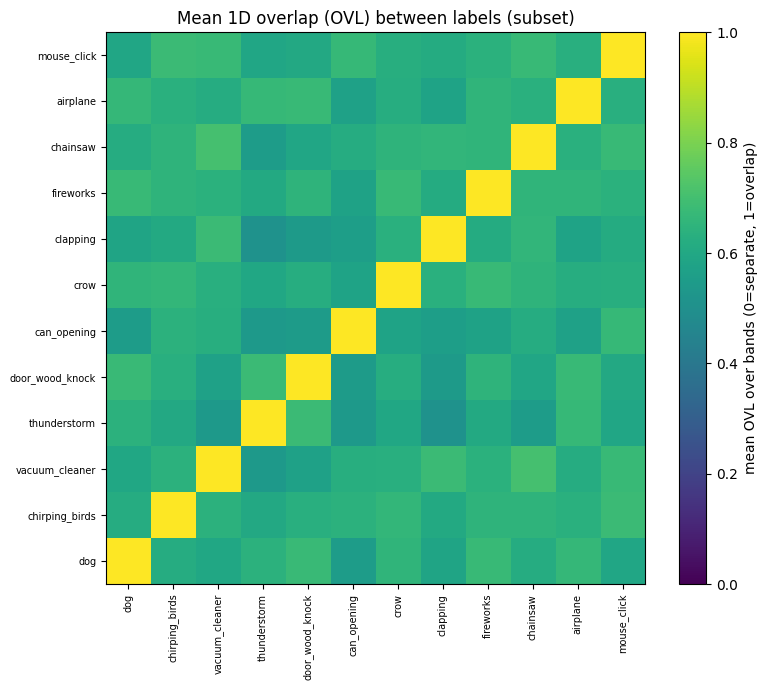

C:\Users\hirok\AppData\Local\Temp\ipykernel_17108\661564994.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  term1 = 0.125 * float(diff.T @ invSr_diff)
C:\Users\hirok\AppData\Local\Temp\ipykernel_17108\661564994.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  term1 = 0.125 * float(diff.T @ invSr_diff)
C:\Users\hirok\AppData\Local\Temp\ipykernel_17108\661564994.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  term1 = 0.125 * float(diff.T @ invSr_diff)
C

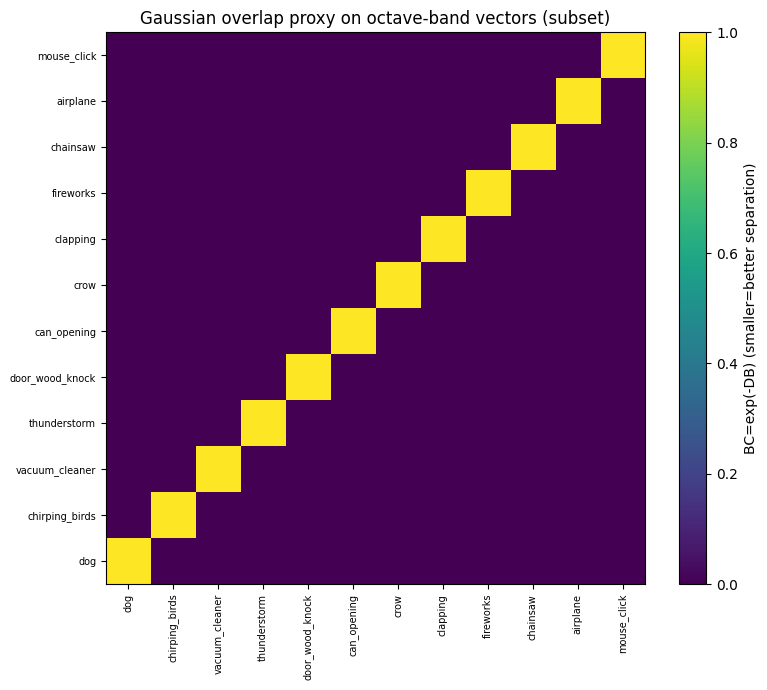

c:\Users\hirok\venv\py312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


kNN mixing score (octave->UMAP): 0.8828666666666667


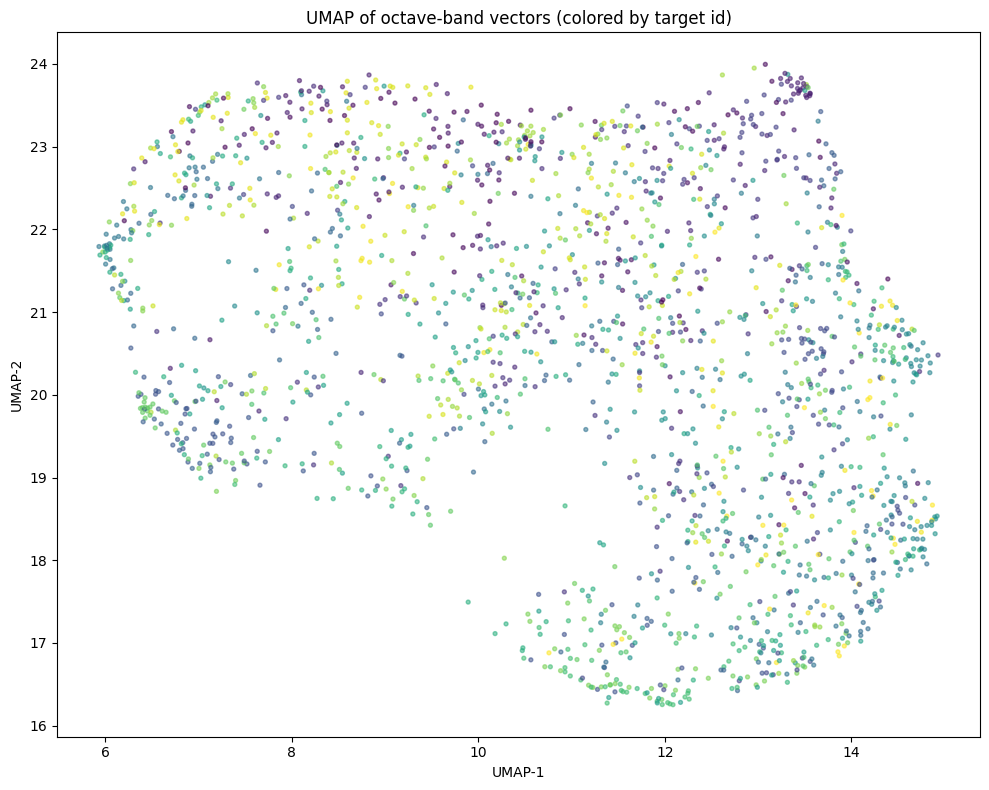

In [10]:
import umap
from sklearn.neighbors import NearestNeighbors

def overlap_coefficient_hist(a: np.ndarray, b: np.ndarray, bins: int = 50) -> float:
    lo = float(min(a.min(), b.min()))
    hi = float(max(a.max(), b.max()))
    if hi <= lo:
        return 1.0
    ha, edges = np.histogram(a, bins=bins, range=(lo, hi), density=True)
    hb, _     = np.histogram(b, bins=edges, density=True)
    dx = edges[1] - edges[0]
    return float(np.sum(np.minimum(ha, hb)) * dx)

def pairwise_overlap_matrix(df_feat: pd.DataFrame, cols: list[str], cats: list[str], bins: int = 50) -> np.ndarray:
    K = len(cats)
    M = np.zeros((K, K), dtype=np.float32)
    for i, ci in enumerate(cats):
        Ai = df_feat[df_feat["category"]==ci]
        for j, cj in enumerate(cats):
            if j < i:
                M[i,j] = M[j,i]
                continue
            Aj = df_feat[df_feat["category"]==cj]
            ovls = []
            for col in cols:
                ovls.append(overlap_coefficient_hist(Ai[col].to_numpy(), Aj[col].to_numpy(), bins=bins))
            M[i,j] = float(np.mean(ovls))
            M[j,i] = M[i,j]
    return M

def bhattacharyya_distance_gaussian(mu0, S0, mu1, S1, eps=1e-6) -> float:
    d = mu0.shape[0]
    S = 0.5*(S0 + S1)
    S0r = S0 + eps*np.eye(d)
    S1r = S1 + eps*np.eye(d)
    Sr  = S  + eps*np.eye(d)
    diff = (mu1 - mu0).reshape(-1,1)
    try:
        invSr_diff = np.linalg.solve(Sr, diff)
        term1 = 0.125 * float(diff.T @ invSr_diff)
        signS, logdetS = np.linalg.slogdet(Sr)
        sign0, logdet0 = np.linalg.slogdet(S0r)
        sign1, logdet1 = np.linalg.slogdet(S1r)
        if signS <= 0 or sign0 <= 0 or sign1 <= 0:
            return float("nan")
        term2 = 0.5 * (logdetS - 0.5*(logdet0 + logdet1))
        return float(term1 + term2)
    except np.linalg.LinAlgError:
        return float("nan")

def gaussian_overlap_proxy(Xa: np.ndarray, Xb: np.ndarray) -> float:
    mu0 = Xa.mean(axis=0)
    mu1 = Xb.mean(axis=0)
    S0  = np.cov(Xa, rowvar=False)
    S1  = np.cov(Xb, rowvar=False)
    DB  = bhattacharyya_distance_gaussian(mu0, S0, mu1, S1)
    if not np.isfinite(DB):
        return float("nan")
    return float(np.exp(-DB))

def pairwise_gauss_overlap(df_feat: pd.DataFrame, cols: list[str], cats: list[str]) -> np.ndarray:
    K = len(cats)
    M = np.zeros((K, K), dtype=np.float32)
    for i, ci in enumerate(cats):
        Xi = df_feat[df_feat["category"]==ci][cols].to_numpy()
        for j, cj in enumerate(cats):
            if j < i:
                M[i,j] = M[j,i]
                continue
            Xj = df_feat[df_feat["category"]==cj][cols].to_numpy()
            M[i,j] = float(gaussian_overlap_proxy(Xi, Xj))
            M[j,i] = M[i,j]
    return M

def knn_mixing_score(Z: np.ndarray, y: np.ndarray, k: int = 15) -> float:
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(Z)
    idx = nbrs.kneighbors(Z, return_distance=False)[:, 1:]
    y_nn = y[idx]
    same = (y_nn == y.reshape(-1,1)).mean(axis=1)
    return float(1.0 - same.mean())

X_oct = df_feat[band_db_cols].to_numpy().astype(np.float32)
y = df_feat["target"].to_numpy().astype(int)

# OVL (subset)
cats_small = df_feat["category"].unique().tolist()[:12]
OV = pairwise_overlap_matrix(df_feat, band_db_cols, cats_small, bins=60)
plt.figure(figsize=(8,7))
plt.imshow(OV, origin="lower", aspect="auto", vmin=0, vmax=1)
plt.colorbar(label="mean OVL over bands (0=separate, 1=overlap)")
plt.title("Mean 1D overlap (OVL) between labels (subset)")
plt.xticks(range(len(cats_small)), cats_small, rotation=90, fontsize=7)
plt.yticks(range(len(cats_small)), cats_small, fontsize=7)
plt.tight_layout()
plt.show()

# Gaussian overlap proxy (subset)
BC = pairwise_gauss_overlap(df_feat, band_db_cols, cats_small)
plt.figure(figsize=(8,7))
plt.imshow(BC, origin="lower", aspect="auto", vmin=0, vmax=np.nanmax(BC))
plt.colorbar(label="BC=exp(-DB) (smaller=better separation)")
plt.title("Gaussian overlap proxy on octave-band vectors (subset)")
plt.xticks(range(len(cats_small)), cats_small, rotation=90, fontsize=7)
plt.yticks(range(len(cats_small)), cats_small, fontsize=7)
plt.tight_layout()
plt.show()

# UMAP mixing
from sklearn.preprocessing import StandardScaler
Xn = StandardScaler().fit_transform(X_oct)
Z = umap.UMAP(n_neighbors=25, min_dist=0.15, random_state=int(cfg["project"]["seed"])).fit_transform(Xn)
print("kNN mixing score (octave->UMAP):", knn_mixing_score(Z, y, k=15))

plt.figure(figsize=(10,8))
plt.scatter(Z[:,0], Z[:,1], c=y, s=8, alpha=0.55)
plt.title("UMAP of octave-band vectors (colored by target id)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
plt.tight_layout(); plt.show()


## 8) 表現を変えて、どれが最もオーバーラップを小さくするか（候補ランキング）

In [11]:
import torch
from src.data.features import FeatureConfig, LogMelExtractor
from tqdm.auto import tqdm

a = cfg["audio"]; f = cfg["features"]
feat_cfg = FeatureConfig(
    sample_rate=int(a.get("sample_rate", 44100)),
    duration_sec=float(a.get("duration_sec", 5.0)),
    n_fft=int(f.get("n_fft", 2048)),
    hop_length=int(f.get("hop_length", 512)),
    win_length=int(f.get("win_length", 2048)),
    n_mels=int(f.get("n_mels", 128)),
    f_min=float(f.get("f_min", 0.0)),
    f_max=None if f.get("f_max") in (None, "null") else float(f.get("f_max")),
    log_eps=float(f.get("log_eps", 1e-6)),
    normalize=str(f.get("normalize", "per_sample")),
)
logmel = LogMelExtractor(feat_cfg)

def logmel_meanstd(x: np.ndarray) -> np.ndarray:
    xt = torch.from_numpy(x).float().unsqueeze(0)
    feat = logmel(xt)
    if isinstance(feat, torch.Tensor):
        feat = feat.detach().cpu().numpy()
    feat = feat[0] if feat.ndim == 3 else feat  # [mel, frames]
    mu = feat.mean(axis=1)
    sd = feat.std(axis=1)
    return np.concatenate([mu, sd], axis=0).astype(np.float32)

def spectral_stats(x: np.ndarray, sr: int) -> np.ndarray:
    f, Pxx = compute_psd(x, sr, nperseg=WELCH_NPERSEG)
    p = Pxx.copy()
    p[p < 1e-20] = 1e-20
    p = p / p.sum()
    centroid = float((f * p).sum())
    bandwidth = float(np.sqrt(((f - centroid)**2 * p).sum()))
    cdf = np.cumsum(p)
    idx = int(np.searchsorted(cdf, 0.85))
    idx = min(max(idx, 0), len(f)-1)
    rolloff = float(f[idx])
    return np.array([centroid, bandwidth, rolloff], dtype=np.float32)

filenames = df_feat["filename"].tolist()
y = df_feat["target"].to_numpy().astype(int)

X_oct = df_feat[band_db_cols].to_numpy().astype(np.float32)

LM_CACHE = CACHE_DIR / "logmel_meanstd.npy"
if LM_CACHE.exists():
    X_lm = np.load(LM_CACHE)
else:
    X_lm = []
    for fn in tqdm(filenames, desc="logmel meanstd"):
        x = load_preprocess(fn, rms_norm=True)
        X_lm.append(logmel_meanstd(x))
    X_lm = np.stack(X_lm, axis=0)
    np.save(LM_CACHE, X_lm)

SS_CACHE = CACHE_DIR / "spectral_stats.npy"
if SS_CACHE.exists():
    X_ss = np.load(SS_CACHE)
else:
    X_ss = []
    for fn in tqdm(filenames, desc="spectral stats"):
        x = load_preprocess(fn, rms_norm=True)
        X_ss.append(spectral_stats(x, SAMPLE_RATE))
    X_ss = np.stack(X_ss, axis=0)
    np.save(SS_CACHE, X_ss)

print("X_oct:", X_oct.shape, "X_lm:", X_lm.shape, "X_ss:", X_ss.shape)


spectral stats: 100%|██████████| 2000/2000 [00:16<00:00, 118.55it/s]

X_oct: (2000, 116) X_lm: (2000, 256) X_ss: (2000, 3)


In [12]:
from itertools import combinations
from sklearn.preprocessing import StandardScaler

def mean_pairwise_gauss_overlap(X: np.ndarray, y: np.ndarray, max_pairs: int = 200, seed: int = 0) -> float:
    rng = np.random.default_rng(seed)
    labels = np.unique(y)
    pairs = list(combinations(labels, 2))
    if len(pairs) > max_pairs:
        pairs = list(rng.choice(pairs, size=max_pairs, replace=False))
    vals = []
    for a, b in pairs:
        Xa = X[y==a]
        Xb = X[y==b]
        vals.append(gaussian_overlap_proxy(Xa, Xb))
    vals = np.array(vals, dtype=float)
    return float(np.nanmean(vals))

def umap_knn_mixing(X: np.ndarray, y: np.ndarray, *, seed: int, n_neighbors: int = 25, min_dist: float = 0.15, k: int = 15) -> float:
    Xn = StandardScaler().fit_transform(X)
    Z = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=seed).fit_transform(Xn)
    return knn_mixing_score(Z, y, k=k)

reps = {
    "octave_band_db": X_oct,
    "logmel_meanstd": X_lm,
    "spectral_stats": X_ss,
}

rows = []
for name, X in reps.items():
    bc = mean_pairwise_gauss_overlap(X, y, max_pairs=250, seed=int(cfg["project"]["seed"]))
    mix = umap_knn_mixing(X, y, seed=int(cfg["project"]["seed"]))
    rows.append({"repr": name, "mean_pairwise_BC": bc, "umap_knn_mixing": mix})

rank = pd.DataFrame(rows).sort_values(["mean_pairwise_BC", "umap_knn_mixing"])
rank


C:\Users\hirok\AppData\Local\Temp\ipykernel_17108\661564994.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  term1 = 0.125 * float(diff.T @ invSr_diff)
c:\Users\hirok\venv\py312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\hirok\AppData\Local\Temp\ipykernel_17108\661564994.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  term1 = 0.125 * float(diff.T @ invSr_diff)
c:\Users\hirok\venv\py312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  

,repr,mean_pairwise_BC,umap_knn_mixing
1,logmel_meanstd,0.000000e+00,0.860067
0,octave_band_db,1.911632e-63,0.882867
2,spectral_stats,3.940578e-01,0.903633


## 9) 次にやると強い分析（提案）

1. 誤ラベル/外れ値検知（上流表現で）
2. クラス内の多峰性（multi-modality）
3. 音響的に意味のある写像（A-weighting 等）
4. モデル表現（CNN/AST埋め込み）とのギャップ可視化

「最もオーバーラップが小さくなる非線形写像」を本気で探すなら：
- UMAP/t-SNE の探索 → kNN mixing を最小化
- さらに進めるなら metric learning（triplet / supervised contrastive）で分離目的の写像を学習
